## Шаблон для проекта по A/B - тестам.

#### chat_id  из Телеграма:

In [ ]:
chat_id = 1141722952

In [2]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import mannwhitneyu, ks_2samp, probplot, norm, ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests

------------------

##  <ins>Задание 1.</ins>

### Условие
#### Контекст
Мы считаем, что наш продукт достаточно дорогой для клиента. У нас есть гипотеза, что уменьшение цены продукта позволит повысить частоту продаж и суммарно увеличит доходность продукта.
#### Тест
Мы проводим тест, в рамках которого контролем является продажа продукта со старой ценой, а тестом - продажа продукта с новой ценой. Целью этого теста является проверка гипотезы роста доходности нашего продукта из-за уменьшения тарифа.
#### Статистические вводные
Уровень значимости 5%. Мы хотели бы различать 5%-ное изменение целевой метрики с вероятностью 80%.

Загрузим исторические данные

In [5]:
df = pd.read_csv('hist_telesales.csv')
df.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


Описание колонок в исторических данных:
- ID - номер задания на звонок
- Флаг дозвона - 1 если в рамках задания мы дозвонились человеку, иначе 0
- Флаг продажи - 1 если в рамках задания мы продали наш продукт человеку, иначе 0
- Расходы - сумма затрат на задание
- PV - 0 если мы не продали наш продукт, иначе = PV проданного продукта
- NPV = PV - Расходы

### Определение целевой метрики

Целевая метрика - NPV, ожидаемый эффект - повышение среднего значения NPV продукта. За счет увеличения частоты продаж и снижения цены общая выручка увеличится и это будет показателем для оценки успеха гипотезы.

Введем основную и альтернативную гипотезы:
- H0: Среднее значение NPV в тестовой и контрольной группах одинаково
- H1: Среднее значение NPV в тестовой группе больше, чем в контрольной

Уровень значимости a = 0.05

Прокси метрики:
- кумулятивное значение NPV
- среднее значение NPV
- изменение NPV тестовой группы относительно контрольной группы

Контрольные метрики:
- конверсия из заявки в продажу продукта
- общая выручка

### Определение размера выборки

Так как хотим проверить одностороннюю альтернативу и имеем небинарное распределение, то минимальный размер выборки будет вычисляться как:

$$ n = m = \frac{2\sigma^2(z_{1-\alpha} - z_\beta)^2}{d^2}$$

In [9]:
alp = 0.05
bet = 0.2
ism = 0.05
variance = df['NPV'].var()
d = df['NPV'].mean() * ism

sample_size = (2 * variance * (norm.ppf(1.0 - alp) - norm.ppf(bet)) ** 2) / (d ** 2)
print('Размер выборки:')
print(round(sample_size))

Размер выборки:
28672


Размер выборки получается: 28672
Получение выборки от бота:

In [11]:
sample_id = 38867
control = pd.read_csv('Контроль.csv')
control.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,1,111,1756,1645
1,1,1,1,338,1202,864
2,2,1,0,44,0,-44
3,3,1,1,443,2089,1646
4,4,0,0,52,0,-52


In [13]:
test = pd.read_csv('Тест.csv')
test.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,0,0,8,0,-8
1,1,0,0,170,0,-170
2,2,0,0,2,0,-2
3,3,1,1,160,1547,1387
4,4,1,0,21,0,-21


### Принятие решения о тесте

Рассчитаем для тестовой и контрольной группы метрики:
- кумулятивное значение NPV
- среднее значение NPV
- сумму продаж продукта
- конверсия из заявки в продажу продукта

In [22]:
test['cum_NPV'] = test['NPV'].cumsum()
test['average_NPV'] = test['NPV'].expanding(min_periods=1).mean()
test['sale_flag'] = test['Флаг продажи'].sum()
test['conversion'] = test['sale_flag'] / len(test)

In [23]:
control['cum_NPV'] = control['NPV'].cumsum()
control['average_NPV'] = control['NPV'].expanding(min_periods=1).mean()
control['sale_flag'] = control['Флаг продажи'].sum()
control['conversion'] = control['sale_flag'] / len(control)

Объединим результаты в датафрейм

In [24]:
data = (control[['ID', 
                 'cum_NPV', 
                 'average_NPV',
                 'conversion']]
        .merge(test[['ID', 
                    'cum_NPV', 
                    'average_NPV', 
                    'conversion']],
                left_on='ID', 
                right_on='ID',
                how='left', 
                suffixes=['_control', '_test']))
data.head()

,ID,cum_NPV_control,average_NPV_control,conversion_control,cum_NPV_test,average_NPV_test,conversion_test
0,0,1645,1645.000000,0.295619,-8,-8.00,0.301409
1,1,2509,1254.500000,0.295619,-178,-89.00,0.301409
2,2,2465,821.666667,0.295619,-180,-60.00,0.301409
3,3,4111,1027.750000,0.295619,1207,301.75,0.301409
4,4,4059,811.800000,0.295619,1186,237.20,0.301409


Рассмотрим, как тестирование повлияло на контрольные и прокси метрики. Построим график кумулятивного NPV, которое выбрали в качестве прокси метрики.

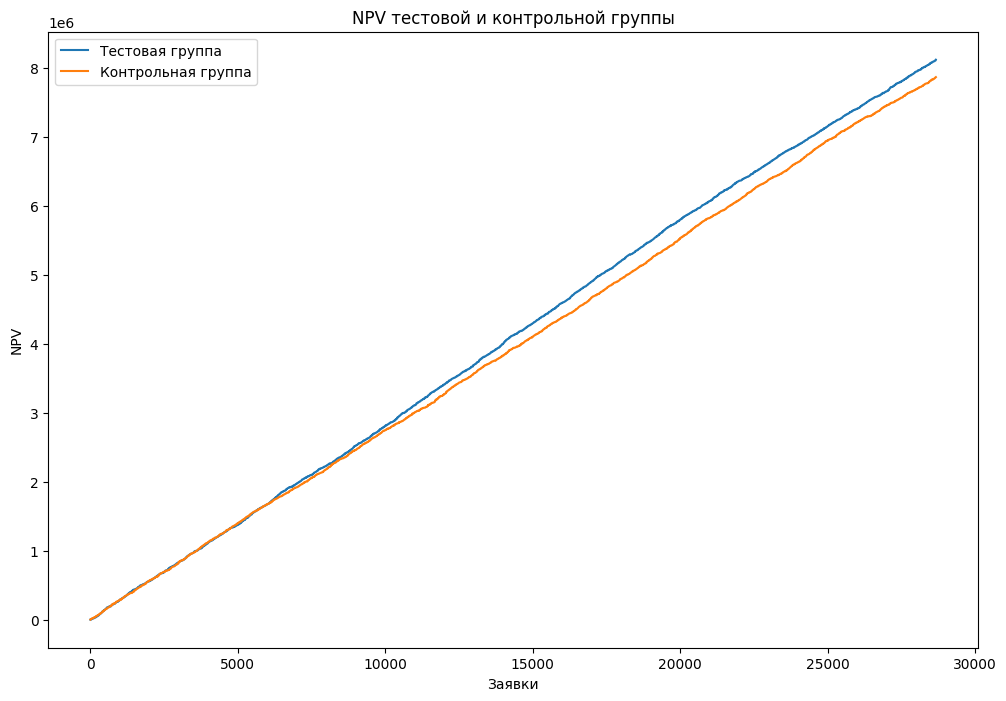

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(test['ID'], test['cum_NPV'], label='Тестовая группа')
plt.plot(control['ID'], control['cum_NPV'], label='Контрольная группа')

current_values = plt.gca().get_yticks()
plt.title('NPV тестовой и контрольной группы')
plt.ylabel('NPV')
plt.xlabel('Заявки')
plt.legend()
plt.show();

Как видно из графика, тестовая группа продемонстрировала более высокий уровень кумулятивного NPV начиная с трети теста, что могло бы указывать на значимые различия в группах.

Также рассмотрим график среднего значения NPV, которая также является одной из выбранных прокси метрик.

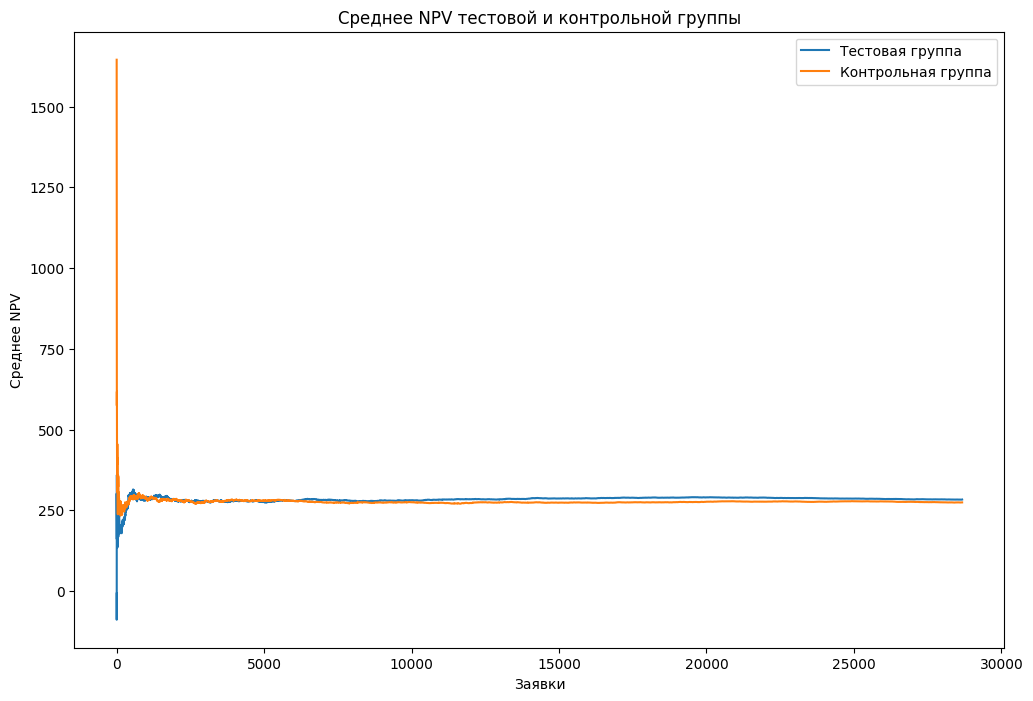

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(test['ID'], test['average_NPV'], label='Тестовая группа')
plt.plot(control['ID'], control['average_NPV'], label='Контрольная группа')


current_values = plt.gca().get_yticks()
plt.title('Среднее NPV тестовой и контрольной группы')
plt.ylabel('Среднее NPV')
plt.xlabel('Заявки')
plt.legend()
plt.show();

------------------

Как видно из графика, тестовая группа и контрольная группа продемонстрировали очень схожий уровень среднего NPV на протяжении всего теста.
Построим также график конверсии тестовой группы к контрольной

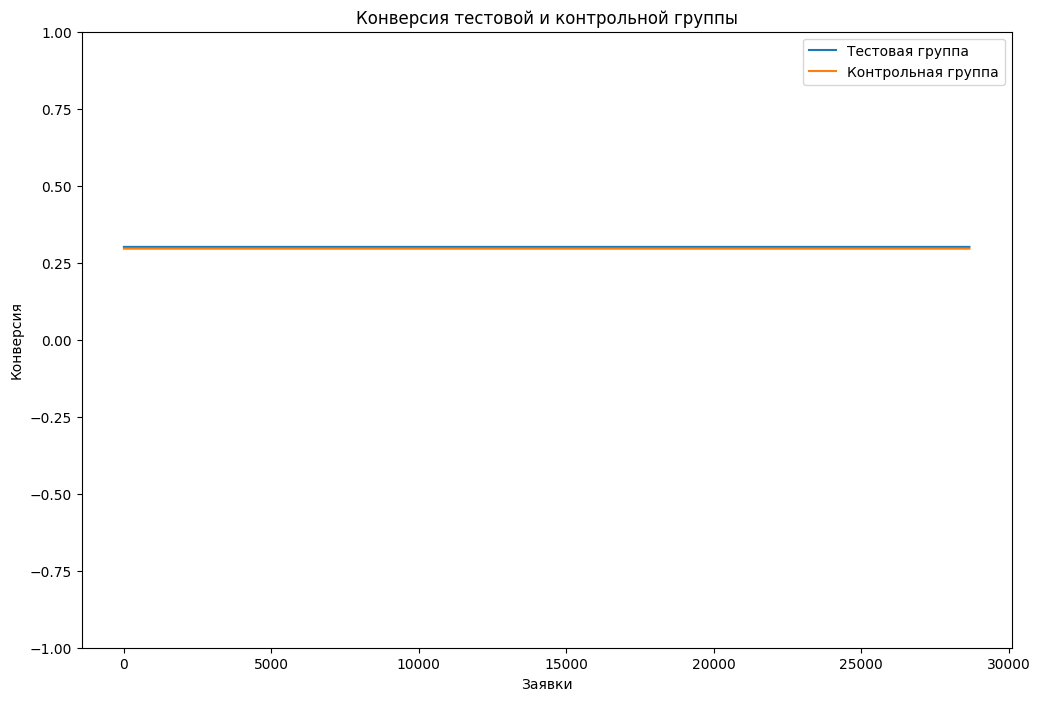

In [46]:
plt.figure(figsize=(12, 8))
plt.ylim(-1,1)
plt.plot(test['ID'], test['conversion'], label='Тестовая группа')
plt.plot(control['ID'], control['conversion'], label='Контрольная группа')


current_values = plt.gca().get_yticks()
plt.title('Конверсия тестовой и контрольной группы')
plt.ylabel('Конверсия')
plt.xlabel('Заявки')
plt.legend()
plt.show();

Как видно из графика, значение конверсии тестовой группы было таким же, что и у контрольной группы.

Воспользуемся критерием Стьюдента для сравнения различий между NPV тестовой и контрольной группы.

In [48]:
stat, p_value = ttest_ind(test['NPV'], control['NPV'], alternative='greater')

print('Процентное различие между средними выборок:',
    '{0:.3f}'.format(
    test['NPV'].mean()/control['NPV'].mean()-1))

print('p-value: ', p_value)

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Процентное различие между средними выборок: 0.032
p-value:  0.05258743053694122
Не отвергаем нулевую гипотезу


Между средними выборок различие в 3.2%, но данное различие не имеет статистической значимости. Полученное p-value составляет 0.0525, что больше уровня значимости 0.05. У нас недостаточно оснований, чтобы отклонить нулевую гипотезу. Процентное различие между средними выборок в размере 3.2% могло быть получено случайно с вероятностью 5.25%.

Так как мы не обнаружили статистической значимости в целевой метрике, рассмотрим различия в конверсии, которая выступает в роли контрольной метрики. Проведем Z-test Фишера.

In [49]:
successes = np.array([test['Флаг продажи'].sum(), control['Флаг продажи'].sum()])
trials = np.array([len(test), len(control)])

stat, pval = proportions_ztest(successes, trials, alternative='larger')

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]

print('p-value: ', pval)
print('Доля тестовой группы:', p1)
print('Доля контрольной группы:', p2)
print('Разница:', (p1 - p2))

if pval < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')


p-value:  0.0649040873448957
Доля тестовой группы: 0.30140904017857145
Доля контрольной группы: 0.29561941964285715
Разница: 0.005789620535714302
Не отвергаем нулевую гипотезу


Таким образом, в процессе проверки гипотез не было обнаружено статистически значимых различий в целевой метрике NPV и также не было обнаружено статистически значимых различий в конверсии групп.

Подводя итоги A/B-тестирования, можно утверждать, что тестовая группа не показала статистически значимых различий в доходности продукта. Уменьшение цены продукта не помогло увеличить частоту продаж. Общее увеличение доходности в метрике NPV могло произойти случайно.